# function defintions 

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from statsmodels.distributions.empirical_distribution import ECDF
from tqdm.auto import tqdm
from collections import namedtuple
from itertools import product
import torch
import torch.nn as nn
import torch.nn.init as init

# Seaborn theme and font scaling for better aesthetics
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {
    "grid.linestyle": ":", 
    "border.color": "black",
    "axes.edgecolor": "black",
    "xtick.bottom": "True",
    "xtick.top": "True",
    "ytick.left": "True",
    "ytick.right": "True",
    "xtick.direction": "in",
    "ytick.direction": "in"
})

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device



/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cpu')

In [2]:



def dict_configs(d, return_dict=False):
    for k, v in d.items():
        if not hasattr(v, '__len__'):
            d[k] = [v]
    Config = namedtuple('Config', d.keys())
    for vcomb in product(*d.values()):
        c = dict(zip(d.keys(), vcomb))
        if return_dict:
            yield Config(**c), c
        else:
            yield Config(**c)



def BN(X):
    X = X - X.mean(dim=0)
    X = X / (X ** 2).mean(dim=0) ** 0.5
    return X

def activation(act='lin'):
    if act == 'tanh':
        return lambda X: torch.tanh(X)
    if act == 'sin':
        return lambda X: torch.sin(X)
    if act == 'cos':
        return lambda X: torch.cos(X)
    if act == 'relu':
        return lambda X: torch.relu(X)
    if act == 'id':
        return lambda X: X
    try:
        return eval(f'torch.{act}')
    except:
        assert False

def gen_input(n, d, distortion=10):
    H = torch.randn(n, d)
    D = torch.ones(n)
    D[0] *= distortion
    D = torch.diag(D)
    svd = torch.svd(H)
    H = svd.U.mm(D.mm(svd.V.t()))
    return H

def create_input(batch_size, input_size, degeneracy=10):
    H = torch.randn(batch_size, input_size)
    D = torch.ones(batch_size)
    D[0] *= degeneracy
    D = torch.diag(D)
    svd = torch.svd(H)
    H = svd.U.mm(D.mm(svd.V.t()))
    return H

class CustomBatchNorm1d(nn.Module):
    def __init__(self):
        super(CustomBatchNorm1d, self).__init__()

    def forward(self, x):
        mean = x.mean(dim=0, keepdim=True)
        std = x.std(dim=0, keepdim=True, unbiased=False)
        x_norm = (x - mean) / std 
        return x_norm 

class CustomActivation(nn.Module):
    def __init__(self, activation):
        super(CustomActivation, self).__init__()

        if activation == 'sin':
            self.activation_fn = torch.sin
        elif activation == 'relu':
            self.activation_fn = torch.relu
        elif activation == 'tanh':
            self.activation_fn = torch.tanh
        elif activation == 'sigmoid':
            self.activation_fn = torch.sigmoid
        elif activation == 'selu':
            self.activation_fn = nn.SELU()
        elif activation == 'linear':
            self.activation_fn = lambda x: x
        else:
            raise ValueError(f"Invalid activation function: {activation}")

    def forward(self, x):
        return self.activation_fn(x)

class CustomMLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, activation='relu', batch_norm=True):
        super(CustomMLP, self).__init__()
        self.layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = CustomActivation(activation)

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        if self.batch_norm:
            self.layers.append(CustomBatchNorm1d())
        
        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            if self.batch_norm:
                self.layers.append(CustomBatchNorm1d())
            self.layers.append(self.activation)
                    
        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                gain = torch.nn.init.calculate_gain(activation)
                init.xavier_normal_(layer.weight, gain=gain)
                init.constant_(layer.bias, 0)

    def forward(self, x, return_hidden=False):
        hidden_activations = [x]
        for layer in self.layers:
            x = layer(x)
            # return activations
            if isinstance(layer, nn.Linear): 
                hidden_activations.append(x)
        
        if return_hidden:
            return hidden_activations[:-1], hidden_activations[-1]
        else:
            return x



def marchenko_pastur_pdf(x, Q, sigma=1):
    # Q = X/Y where X is number of samples and Y is number of features
    # sigma is the standard deviation of the samples.
    b = sigma * np.power((1 + np.sqrt(1/Q)),2)
    a = sigma * np.power((1 - np.sqrt(1/Q)),2)
    pdf = Q**2*(1/(2*np.pi*sigma*sigma*Q*x))*np.sqrt((b-x)*(x-a))*(x>a)*(x<b)
    pdf[np.isnan(pdf)] = 0
    return pdf
    
def calc_G_star(matrix):
    diagonal_mean = np.mean(np.diag(matrix))
    np.fill_diagonal(matrix, diagonal_mean)
    off_diagonal_mean = np.mean(matrix[~np.eye(matrix.shape[0], dtype=bool)])
    matrix[~np.eye(matrix.shape[0], dtype=bool)] = off_diagonal_mean


def run_experiment(G, calc_eigs=False):
    df = []
    for c, conf in tqdm(list(dict_configs(G, return_dict=True)), leave=False): 
        hidden_sizes = [c.d] * c.depth
        sample_input = create_input(c.n, c.input_size, c.degeneracy)
        mlp = CustomMLP(c.input_size, c.output_size, hidden_sizes, c.activation, c.batch_norm)
        mlp.to(device)
        hidden_layers, output = mlp(sample_input.to(device), return_hidden=True)
        for l, X in enumerate(hidden_layers):
            G = X @ X.T / c.d
            eigs = None
            if calc_eigs:
                eigs = torch.linalg.eigvalsh(G)
                eigs = eigs.detach().cpu().numpy()
            df.append({**conf, 'l': l, 'G': G.detach().cpu().numpy(), 'eigs': eigs})

    df = pd.DataFrame(df)

    G_star = df.groupby(['d', 'n', 'activation', 'depth','batch_norm'])['G'].apply(lambda x: np.mean(np.stack(x), 0)).reset_index()
    G_star = G_star.loc[(G_star.d == G_star.d.max()) & (G_star.depth == G_star.depth.max())]
    G_star.G.apply(calc_G_star)
    df = pd.merge(df, G_star, how='left', on=['n', 'activation','batch_norm'], suffixes=('', '_star'))
    df.loc[:, 'G_diff'] = df.G_star - df.G
    df.loc[:, 'G_diff_fro'] = df.G_diff.apply(lambda x: np.sum(x**2)**0.5)
    df.loc[:, 'G_star_cond'] = df.G_star.apply(lambda x: np.linalg.cond(x))
    alpha = 0.5
    df.loc[:, 'theory'] = df.apply(lambda x: 2*x.G_star_cond * ((1 - alpha)**(x.l / 2) + 0.25 * x.n / np.sqrt(x.d) / alpha), axis=1)

    return df


def plot_results(df, x, y, estimator, hue=None, linestyle=None, color=None, marker=None, 
                 xlabel=None, ylabel=None, title=None, log_xscale=False, log_yscale=False, save_path=None):
    plt.figure()
    sns.lineplot(data=df, x=x, y=y, estimator=estimator, hue=hue, linestyle=linestyle, color=color, marker=marker)
    df = df.groupby([x])['theory'].agg(np.median).reset_index()
    sns.lineplot(data=df, x=x, y='theory', linestyle='--', color='k', label='theory')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if log_yscale:
        plt.yscale('log')
    if log_xscale:
        plt.xscale('log')
    if title:
        plt.title(title)
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()





def dict_configs(d, return_dict=False):
    for k, v in d.items():
        if not hasattr(v, '__len__'):
            d[k] = [v]
    Config = namedtuple('Config', d.keys())
    for vcomb in product(*d.values()):
        c = dict(zip(d.keys(), vcomb))
        if return_dict:
            yield Config(**c), c
        else:
            yield Config(**c)


def BN(X):
    X = X - X.mean(dim=0)
    X = X / (X ** 2).mean(dim=0) ** 0.5
    return X

def activation(act='lin'):
    if act == 'tanh':
        return lambda X: torch.tanh(X)
    if act == 'sin':
        return lambda X: torch.sin(X)
    if act == 'cos':
        return lambda X: torch.cos(X)
    if act == 'relu':
        return lambda X: torch.relu(X)
    if act == 'id':
        return lambda X: X
    try:
        return eval(f'torch.{act}')
    except:
        assert False

def gen_input(n, d, distortion=10):
    H = torch.randn(n, d)
    D = torch.ones(n)
    D[0] *= distortion
    D = torch.diag(D)
    svd = torch.svd(H)
    H = svd.U.mm(D.mm(svd.V.t()))
    return H

def create_input(batch_size, input_size, degeneracy=10):
    H = torch.randn(batch_size, input_size)
    D = torch.ones(batch_size)
    D[0] *= degeneracy
    D = torch.diag(D)
    svd = torch.svd(H)
    H = svd.U.mm(D.mm(svd.V.t()))
    return H

class CustomBatchNorm1d(nn.Module):
    def __init__(self):
        super(CustomBatchNorm1d, self).__init__()

    def forward(self, x):
        mean = x.mean(dim=0, keepdim=True)
        std = x.std(dim=0, keepdim=True, unbiased=False)
        x_norm = (x - mean) / std 
        return x_norm 

class CustomActivation(nn.Module):
    def __init__(self, activation):
        super(CustomActivation, self).__init__()

        if activation == 'sin':
            self.activation_fn = torch.sin
        elif activation == 'relu':
            self.activation_fn = torch.relu
        elif activation == 'tanh':
            self.activation_fn = torch.tanh
        elif activation == 'sigmoid':
            self.activation_fn = torch.sigmoid
        elif activation == 'selu':
            self.activation_fn = nn.SELU()
        elif activation == 'linear':
            self.activation_fn = lambda x: x
        else:
            raise ValueError(f"Invalid activation function: {activation}")

    def forward(self, x):
        return self.activation_fn(x)

class CustomMLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, activation='relu', batch_norm=True):
        super(CustomMLP, self).__init__()
        self.layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = CustomActivation(activation)

        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        if self.batch_norm:
            self.layers.append(CustomBatchNorm1d())
        
        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            if self.batch_norm:
                self.layers.append(CustomBatchNorm1d())
            self.layers.append(self.activation)
                    
        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                gain = torch.nn.init.calculate_gain(activation)
                init.xavier_normal_(layer.weight, gain=gain)
                init.constant_(layer.bias, 0)

    def forward(self, x, return_hidden=False):
        hidden_activations = [x]
        for layer in self.layers:
            x = layer(x)
            # return activations
            if isinstance(layer, nn.Linear): 
                hidden_activations.append(x)
        
        if return_hidden:
            return hidden_activations[:-1], hidden_activations[-1]
        else:
            return x



def marchenko_pastur_pdf(x, Q, sigma=1):
    # Q = X/Y where X is number of samples and Y is number of features
    # sigma is the standard deviation of the samples.
    b = sigma * np.power((1 + np.sqrt(1/Q)),2)
    a = sigma * np.power((1 - np.sqrt(1/Q)),2)
    pdf = Q**2*(1/(2*np.pi*sigma*sigma*Q*x))*np.sqrt((b-x)*(x-a))*(x>a)*(x<b)
    pdf[np.isnan(pdf)] = 0
    return pdf
    
def calc_G_star(matrix):
    diagonal_mean = np.mean(np.diag(matrix))
    np.fill_diagonal(matrix, diagonal_mean)
    off_diagonal_mean = np.mean(matrix[~np.eye(matrix.shape[0], dtype=bool)])
    matrix[~np.eye(matrix.shape[0], dtype=bool)] = off_diagonal_mean


def run_experiment(G, calc_eigs=False):
    df = []
    for c, conf in tqdm(list(dict_configs(G, return_dict=True)), leave=False): 
        hidden_sizes = [c.d] * c.depth
        sample_input = create_input(c.n, c.input_size, c.degeneracy)
        mlp = CustomMLP(c.input_size, c.output_size, hidden_sizes, c.activation, c.batch_norm)
        mlp.to(device)
        hidden_layers, output = mlp(sample_input.to(device), return_hidden=True)
        for l, X in enumerate(hidden_layers):
            G = X @ X.T / c.d
            eigs = None
            if calc_eigs:
                eigs = torch.linalg.eigvalsh(G)
                eigs = eigs.detach().cpu().numpy()
            df.append({**conf, 'l': l, 'G': G.detach().cpu().numpy(), 'eigs': eigs})

    df = pd.DataFrame(df)

    G_star = df.groupby(['d', 'n', 'activation', 'depth','batch_norm'])['G'].apply(lambda x: np.mean(np.stack(x), 0)).reset_index()
    G_star = G_star.loc[(G_star.d == G_star.d.max()) & (G_star.depth == G_star.depth.max())]
    G_star.G.apply(calc_G_star)
    df = pd.merge(df, G_star, how='left', on=['n', 'activation','batch_norm'], suffixes=('', '_star'))
    df.loc[:, 'G_diff'] = df.G_star - df.G
    df.loc[:, 'G_diff_fro'] = df.G_diff.apply(lambda x: np.sum(x**2)**0.5)
    df.loc[:, 'G_star_cond'] = df.G_star.apply(lambda x: np.linalg.cond(x))
    alpha = 0.5
    df.loc[:, 'theory'] = df.apply(lambda x: 2*x.G_star_cond * ((1 - alpha)**(x.l / 2) + 0.25 * x.n / np.sqrt(x.d) / alpha), axis=1)

    return df


def plot_results(df, x, y, estimator, hue=None, linestyle=None, color=None, marker=None, 
                 xlabel=None, ylabel=None, title=None, log_xscale=False, log_yscale=False, save_path=None):
    plt.figure()
    sns.lineplot(data=df, x=x, y=y, estimator=estimator, hue=hue, linestyle=linestyle, color=color, marker=marker)
    df = df.groupby([x])['theory'].agg(np.median).reset_index()
    sns.lineplot(data=df, x=x, y='theory', linestyle='--', color='k', label='theory')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if log_yscale:
        plt.yscale('log')
    if log_xscale:
        plt.xscale('log')
    if title:
        plt.title(title)
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    plt.show()






# Relationship between mean-field error, depth, width, and batch size 

### The MLP setup 
In the given setup, $h_\ell\in \R^{d\times n}$ represents the hidden representation at layer $\ell$. Here, $n$ corresponds to the mini-batch size, and $d$ denotes the constant width of the network across all layers. The sequence ${h_\ell}$ forms a Markov chain described by:

\begin{align*}
h_{\ell+1}:=W_\ell \sigma \circ\phi(h_\ell), && W_\ell\sim N (0,\frac1d)^{d\times d},
\end{align*}

In the above equation, $h_0\in\R^{d\times n}$ represents the input batch, $\sigma$ is the element-wise activation function, and $\phi$ refers to batch normalization \cite{ioffe2015batch}. Batch normalization performs row-wise centering and scaling by standard deviation, given as:

\begin{align*}
\phi(x) = \frac{x - \text{mean}(x)}{\sqrt{\text{Var}(x)}}, && \forall r: \text{row}_r(\phi(h)) = \phi(\text{row}_r(h)).
\end{align*}

### The main theorem

Assuming the Markov chain of representations $\{h_\ell\}$ is rapidly mixing with $\alpha >0$ and has a non-degenerate fixed-point $G_*$. If the activation $\sigma$ is uniformly bounded, i.e., $|\sigma(x)| = O(|x|)$, then the Gram matrix deviation $|G_*-G_\ell|_F$ is bounded by

\begin{align}
\kappa(G_*) O\left((1-\alpha)^{\frac{\ell}{2}}+ \frac{n}{\sqrt{d}}\alpha^{-\frac12}\ln^{\frac12}(\frac{d}{n}) \right),
\end{align}

with high probability in $d$ and $\ell$.

### Empirical validations 
In the following, we validate the trends of $\|G_\ell - G_*\|_F$ with respect to  $n,d$ and $\ell$. Here are some details of the experiments:
- $G_*$  In order to approximate $G_*$, we use a large value for $\ell$ and $d$, and then average the off-diagonal and diagonal values to approximate $G_*$. 
- We use $\alpha = 0.5$ for all the experiments. This value is not a result of the theorem, but rather is chosen to as a sufficiently large value that is stricly less than $1$ to ensure rapid mixing with $1-\alpha$ rate. 

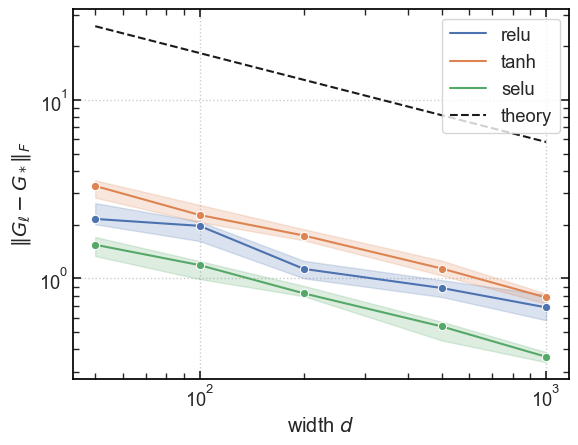

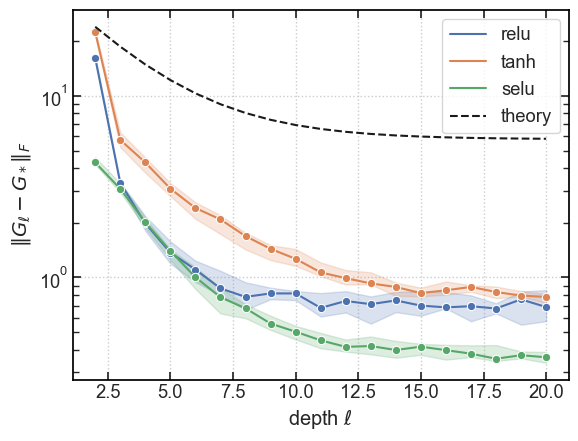

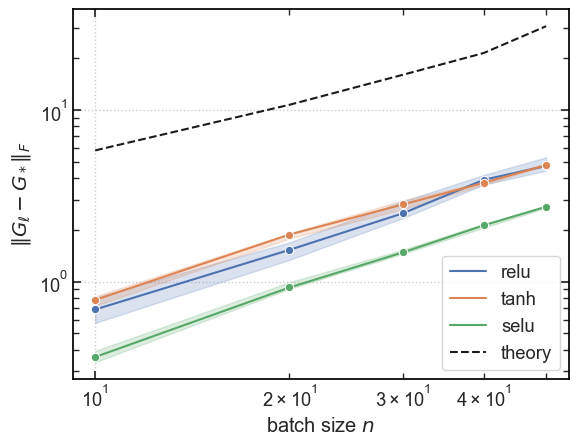

In [4]:
def theory_validation_figs():
    # Define the hyperparameter grid
    G = {
        'd': [50, 100, 200, 500, 1000],
        'n': [10, 20, 30, 40, 50],
        'activation': ['relu', 'tanh', 'selu'], 
        'it': range(10),
        'degeneracy': [20],
        'depth': [20],
        'input_size': [1000],
        'output_size': [1000],
        'batch_norm': [True],
    }

    # Run the experiment
    df = run_experiment(G)
    alpha = 0.5
    df.loc[:, 'theory'] = df.apply(lambda x: 2*x.G_star_cond * ((1 - alpha)**(x.l / 2) + 0.25 * x.n / np.sqrt(x.d) / alpha), axis=1)

    # Plot results
    estimator = np.median

    df2 = df.loc[(df.n == df.n.min()) & (df.l == df.l.max())]
    plot_results(df2, x='d', y='G_diff_fro', 
                 log_xscale=True, log_yscale=True,
                 estimator=estimator, hue='activation', marker='o',
                 xlabel='width $d$', ylabel='$\|G_\ell-G_*\|_F$',
                 save_path='icml_plots/Gram_diff_vs_d.pdf')

    df2 = df.loc[(df.d == df.d.max()) & (df.n == df.n.min())]
    df2 = df2.loc[df.l > 1]
    plot_results(df2, x='l', y='G_diff_fro', estimator=estimator, hue='activation', marker='o',
                 log_yscale=True,
                 xlabel='depth $\ell$', ylabel='$\|G_\ell-G_*\|_F$',
                 save_path='icml_plots/Gram_diff_vs_l.pdf')

    df2 = df.loc[(df.d == df.d.max()) & (df.l == df.l.max())]
    plot_results(df2, x='n', y='G_diff_fro', estimator=estimator, hue='activation', marker='o',
                 xlabel='batch size $n$', ylabel='$\|G_\ell-G_*\|_F$',
                 log_xscale=True, log_yscale=True,
                 save_path='icml_plots/Gram_diff_vs_n.pdf')

theory_validation_figs()

# Emprical spectral distribution of hidden representations 

In [ ]:
def ESD_fig():
    # Define the hyperparameter grid
    G = {
        'd': [1000],
        'n': [20],
        'activation': ['tanh', 'relu'], 
        'it': range(10),
        'degeneracy': [1],
        'depth': [20],
        'input_size': [1000],
        'output_size': [1000],
        'batch_norm': [True],
    }
    
    # Run the experiment
    df = run_experiment(G, calc_eigs=True)
    df2 = df.loc[df.l == df.l.max() - 1].explode('eigs')
    df2.eigs = df2.eigs ** 0.5
    median_eigs = df2.groupby('activation')['eigs'].median()
    df2['eigs_normalized'] = df2.groupby('activation')['eigs'].transform(lambda x: x / median_eigs[x.name])
    
    # Plot the histogram of normalized eigenvectors
    x = np.arange(0, 4, 0.05)
    g = sns.FacetGrid(df2, hue='activation', height=5)
    g.map(sns.histplot, 'eigs_normalized', stat='density', bins=x, alpha=0.5)
    g.set(xlabel='singular values of $h_\ell$', ylabel='Density')
    g.fig.tight_layout()
    
    # Calculate gamma value
    gamma = df.n.iloc[0] / df.d.iloc[0]
    pdf = marchenko_pastur_pdf(x, 1.0/gamma)
    
    # Plot the PDF with dashed line and label
    plt.plot(x, pdf, '--', label=f'MP $\gamma={gamma}$', color='k')
    plt.legend()
    plt.savefig('icml_plots/singular_values_relu_tanh.pdf', format='pdf', bbox_inches='tight')
    plt.show()



def plot_histogram(df, x, colors):
    for act in df.act.unique():
        plt.figure()
        for c, gamma in zip(colors, df.gamma.unique()[:]):
            df2 = df.loc[(df.act == act) & (df.gamma == gamma) & (df.l == df.l.max())]
            n = df2.n.iloc[0]
            d = df2.d.iloc[0]
            gamma = df2.gamma.iloc[0]
            pdf = marchenko_pastur_pdf(x, 1.0/gamma)
            plt.plot(x, pdf, '--', label=f'MP $\gamma={gamma}$', color=c)
            values = df2.H_eig.values
            plt.hist(values / np.median(values), color=c, density=True, alpha=0.2, bins=x, label=f'n={n}, d={d}')
            plt.title(act)
        plt.legend()
        plt.xlabel('Singular values $h_\ell$')
        plt.ylabel('Density')
        plt.savefig(f'icml_plots/singular_values_{act}.pdf', format='pdf')
        plt.show()


def ESD_supplementary():
    Num = 1
    L = 20
    # Lists to store results
    all_results = []
    df = []

    # Loop over activation functions
    for act in ['relu', 'tanh', 'sin', 'selu', 'celu', 'sigmoid']:
        F = activation(act)

        # Loop over different values of d
        for d in [1000, 2000, 5000]:
            n = 500
            gamma = n / d
            results = []

            for it in range(Num):
                # create input 
                H = torch.randn(L + 1, n, d).to(device)  

                sings = []

                for l in range(1, L + 1):
                    W = torch.randn(d, d).to(device) / np.sqrt(d)
                    A = 1 / (d ** 0.5) * F(BN(H[l - 1]))
                    S = torch.svd(A, compute_uv=False).S
                    sings.append(S.cpu())
                    H[l] = A.mm(W)
                    HS = torch.svd(H[l], compute_uv=False).S
                    for ei, (e, he) in enumerate(zip(S.cpu().numpy(), HS.cpu().numpy())):
                        df.append(dict(it=it, n=n, d=d, l=l, act=act, eig_rank=ei, A_eig=e, H_eig=he, gamma=gamma))

                sings = torch.stack(sings)
                results.append(sings)

            results = torch.stack(results)
            all_results.append((n, d, gamma, results))

    df = pd.DataFrame(df)
    plot_histogram(df, x=np.arange(0.01, 7, 0.1), colors=sns.color_palette("Dark2"))


ESD_fig()

ESD_supplementary()